# Feature Drift

To understand feature drift, the below metrics can be monitored.

- P value from KS test
- PSI(Population stability index)
- WD(Wasserstein Distance)

## KS Test - Kolmogorov-SmirnovKolmogorov-Smirnov

The Kolmogorov-Smirnov test (KS test) is a nonparametric statistical test used to compare two distributions. It assesses whether two samples come from the same underlying distribution or if a sample follows a specific theoretical distribution (e.g., normal distribution). The test is based on the maximum difference between the cumulative distribution functions (CDFs) of the two datasets.

Test Statistic: The KS statistic (D) is the maximum absolute difference between the CDFs of the two distributions:

$D = \sup_x |F_1(x) - F_2(x)|$

where $ F_1(x) $ and $ F_2(x) $ are the CDFs of the two distributions, and $\sup$ denotes the supremum (maximum).

### Key Points:
#### Purpose:
- One-sample KS test: Compares a sample's empirical distribution to a reference distribution (e.g., normal, uniform).
- Two-sample KS test: Compares the empirical distributions of two samples.

### Use Cases:
- Checking if a dataset follows a specific distribution (e.g., normality test).
- Comparing two datasets to see if they come from the same population.


### Limitations:
- Less sensitive to differences in the tails of distributions.
- Works best with continuous distributions; less reliable for discrete distributions.
- For small sample sizes, the test may lack power.

KS Statistic: 0.3870, P-value: 0.0000


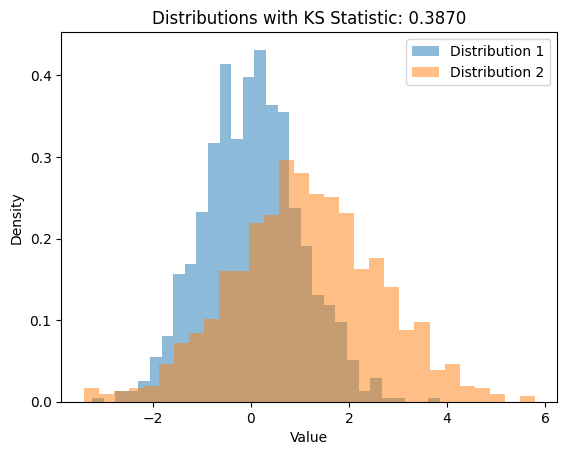

In [3]:
import numpy as np
from scipy.stats import ks_2samp
import matplotlib.pyplot as plt

# Generate sample data from two normal distributions
np.random.seed(42)
dist1 = np.random.normal(loc=0, scale=1, size=1000)  # Mean=0, Std=1
dist2 = np.random.normal(loc=1, scale=1.5, size=1000)  # Mean=1, Std=1.5

# Compute Kolmogorov-Smirnov statistic
ks_stat, p_value = ks_2samp(dist1, dist2)
print(f"KS Statistic: {ks_stat:.4f}, P-value: {p_value:.4f}")

# Visualize the distributions
plt.hist(dist1, bins=30, alpha=0.5, label='Distribution 1', density=True)
plt.hist(dist2, bins=30, alpha=0.5, label='Distribution 2', density=True)
plt.title(f"Distributions with KS Statistic: {ks_stat:.4f}")
plt.xlabel("Value")
plt.ylabel("Density")
plt.legend()
plt.show()

## PSI - Population stability index

PSI quantifies the difference between two probability distributions (e.g., expected vs. actual) by comparing the proportion of observations in predefined bins or categories. The formula is:

$PSI = \sum_{i} \left[ (\% \text{Actual}_i - \% \text{Expected}_i) \times \ln\left(\frac{\% \text{Actual}_i}{\% \text{Expected}_i}\right) \right]$

Where:

- $\% \text{Actual}_i$: Percentage of observations in the $i$-th bin for the new (actual) dataset.
- $\% \text{Expected}_i$: Percentage of observations in the $i$-th bin for the baseline (expected) dataset.
- $\ln$: Natural logarithm.
- $i$: Index for each bin or category.

Interpretation
- PSI < 0.1: Indicates little to no change in the population distribution (stable).
- PSI 0.1–0.25: Suggests moderate change, warranting investigation.
- PSI > 0.25: Indicates significant shift, often requiring model retraining or adjustment.

The Population Stability Index (PSI) has limitations:
- Sensitive to binning choices, which can distort results.
- Ignores feature correlations and only measures distribution shifts.
- Lacks directional insight and relies on subjective thresholds.
- Edge cases (e.g., zero counts) require adjustments that may introduce bias.
- Assumes clean data and doesn’t assess model performance impact.

Population Stability Index (PSI): 1.4915


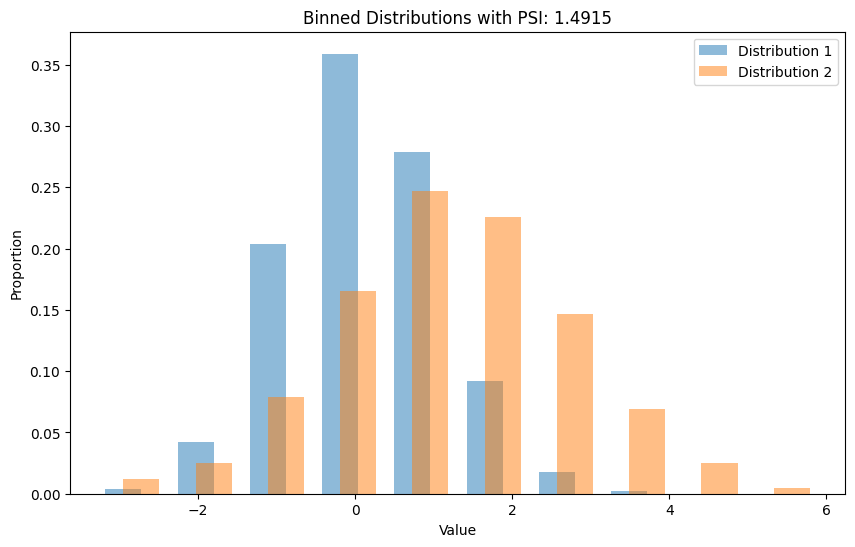

In [5]:
import numpy as np
import matplotlib.pyplot as plt

def calculate_psi(expected, actual, bins=10):
    """Calculate PSI between two distributions."""
    # Define bin edges
    bin_edges = np.histogram_bin_edges(np.concatenate([expected, actual]), bins=bins)
    
    # Compute histograms (proportions)
    expected_counts, _ = np.histogram(expected, bins=bin_edges, density=True)
    actual_counts, _ = np.histogram(actual, bins=bin_edges, density=True)
    
    # Normalize to get proportions (sum to 1)
    expected_prop = expected_counts / np.sum(expected_counts)
    actual_prop = actual_counts / np.sum(actual_counts)
    
    # Avoid division by zero or log(0) by adding small epsilon
    epsilon = 1e-10
    expected_prop = np.clip(expected_prop, epsilon, 1)
    actual_prop = np.clip(actual_prop, epsilon, 1)
    
    # Calculate PSI
    psi = np.sum((expected_prop - actual_prop) * np.log(expected_prop / actual_prop))
    
    return psi, bin_edges, expected_prop, actual_prop

# Generate sample data from two normal distributions
np.random.seed(42)
dist1 = np.random.normal(loc=0, scale=1, size=1000)  # Mean=0, Std=1
dist2 = np.random.normal(loc=1, scale=1.5, size=1000)  # Mean=1, Std=1.5

# Compute PSI
psi_value, bin_edges, expected_prop, actual_prop = calculate_psi(dist1, dist2, bins=10)
print(f"Population Stability Index (PSI): {psi_value:.4f}")

# Visualize the binned distributions
plt.figure(figsize=(10, 6))
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
plt.bar(bin_centers, expected_prop, width=(bin_edges[1] - bin_edges[0]) / 2, alpha=0.5, label='Distribution 1')
plt.bar(bin_centers, actual_prop, width=(bin_edges[1] - bin_edges[0]) / 2, alpha=0.5, label='Distribution 2', align='edge')
plt.title(f"Binned Distributions with PSI: {psi_value:.4f}")
plt.xlabel("Value")
plt.ylabel("Proportion")
plt.legend()
plt.show()

## WD -Wasserstein Distance

The Wasserstein Distance measures the minimum "work" required to transform one probability distribution into another,

Mathematically, for one-dimensional distributions, the first Wasserstein Distance (W1) between two distributions $ P $ (reference) and $ Q $ (current) with cumulative distribution functions (CDFs) $ \hat{F}_{P} $ and $ \hat{F}_{Q} $ is:
$ W_1(P, Q) = \int_{-\infty}^{\infty} |\hat{F}_{P}(x) - \hat{F}_{Q}(x)| \, dx $

**Advantages of Wasserstein Distance (WD) for Feature Drift Monitoring**:
- Captures both shape and location shifts in distributions, making it sensitive to subtle drifts.
- Robust to non-overlapping distributions and outliers, unlike KL or KS metrics.
- Intuitive interpretation as the "cost" of transforming distributions, especially when normalized.
- Effective for numerical features in high-dimensional data, like sensor or image features.

**Limitations**:
- Primarily suited for numerical features; less effective for categorical data.
- Depends on histogram binning, which can affect results if not consistent.
- Unbounded metric complicates cross-feature comparisons without normalization.
- Computationally intensive for large or high-dimensional datasets.

What the Value Represents:

The Wasserstein Distance is a non-negative number (≥ 0).
- A smaller value (e.g., close to 0) means the two distributions are very similar. If $ W_p(\mu, \nu) = 0 $, the distributions are identical.
- A larger value indicates greater dissimilarity, reflecting more "work" needed to transform one distribution into the other.
- The value depends on the order $ p $ (e.g., $ p=1 $ or $ p=2 $) and the scale of the data. For $ p=1 $, the distance is in the same units as the data; for $ p=2 $, it’s the square root of a sum of squared distances.

Wasserstein Distance: 1.1039


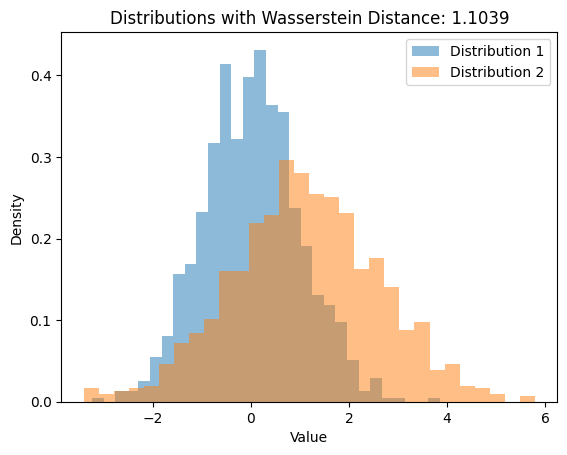

In [4]:
import numpy as np
from scipy.stats import wasserstein_distance
import matplotlib.pyplot as plt

# Generate sample data from two normal distributions
np.random.seed(42)
dist1 = np.random.normal(loc=0, scale=1, size=1000)  # Mean=0, Std=1
dist2 = np.random.normal(loc=1, scale=1.5, size=1000)  # Mean=1, Std=1.5

# Compute Wasserstein Distance
w_distance = wasserstein_distance(dist1, dist2)
print(f"Wasserstein Distance: {w_distance:.4f}")

# Visualize the distributions
plt.hist(dist1, bins=30, alpha=0.5, label='Distribution 1', density=True)
plt.hist(dist2, bins=30, alpha=0.5, label='Distribution 2', density=True)
plt.title(f"Distributions with Wasserstein Distance: {w_distance:.4f}")
plt.xlabel("Value")
plt.ylabel("Density")
plt.legend()
plt.show()

## comparison

| **Metric** | **Definition** | **Use Case** | **Pros** | **Cons** |
|------------|----------------|--------------|----------|----------|
| **Wasserstein Distance (WD)** | Cost to transform one distribution into another (optimal transport). | GAN training, distribution alignment. | Captures geometric differences, works for continuous/discrete data. | Computationally expensive, sensitive to scale. |
| **Kolmogorov-Smirnov (KS)** | Max distance between two CDFs. | Two-sample tests, model validation. | Simple, non-parametric, widely used. | Less sensitive to tails, not ideal for high dimensions. |
| **Population Stability Index (PSI)** | Measures distribution shift via binned proportions. | Data drift detection, model monitoring. | Easy to compute, industry-standard for stability. | Binning-dependent, not a true metric. |

## Best Practice

- Use more than 1 metrics to trigger drfit alert reason being 1 metric might be sensitve at times